In [1]:
import numpy as np
import pandas as pd
import time
import datetime
from optuna import create_study, samplers
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.model_selection import cross_val_score, TunedThresholdClassifierCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
import xgboost as xgb
import boto3
import pickle
from sklearn.feature_selection import SelectKBest, f_classif

import warnings
warnings.filterwarnings("ignore")

In [2]:
def objective(self, trial, X, y):
    
    model_name = trial.suggest_categorical('model', ['random_forest', 'gradient_boosting', 'xgboost'])
    
    if model_name == 'random_forest':
        n_estimators = trial.suggest_int('rf_n_estimators', 100, 500)  
        max_depth = trial.suggest_int('rf_max_depth', 5, 25)  
        min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 15)
        min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 8)
        max_features = trial.suggest_categorical('rf_max_features', ['sqrt', 'log2', 0.3, 0.5])  
        class_weight = trial.suggest_categorical('rf_class_weight', [None, 'balanced', 'balanced_subsample'])
        
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            class_weight=class_weight,
            random_state=42,
            n_jobs=-1
        )
    
    elif model_name == 'gradient_boosting':
        n_estimators = trial.suggest_int('gb_n_estimators', 100, 500)  # Más estimadores
        learning_rate = trial.suggest_float('gb_learning_rate', 0.01, 0.2, log=True)
        max_depth = trial.suggest_int('gb_max_depth', 3, 12)  # Más profundidad
        subsample = trial.suggest_float('gb_subsample', 0.7, 1.0)
        max_features = trial.suggest_categorical('gb_max_features', ['sqrt', 'log2', None, 0.3, 0.5])
        min_samples_split = trial.suggest_int('gb_min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('gb_min_samples_leaf', 1, 10)
        
        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            max_features=max_features,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        
    elif model_name == 'xgboost':
        n_estimators = trial.suggest_int('xgb_n_estimators', 100, 800)  # Más estimadores
        learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True)
        max_depth = trial.suggest_int('xgb_max_depth', 3, 12)
        min_child_weight = trial.suggest_int('xgb_min_child_weight', 1, 10)
        subsample = trial.suggest_float('xgb_subsample', 0.7, 1.0)
        colsample_bytree = trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0)
        reg_alpha = trial.suggest_float('xgb_reg_alpha', 0, 10)
        reg_lambda = trial.suggest_float('xgb_reg_lambda', 0, 10)
        gamma = trial.suggest_float('xgb_gamma', 0, 5)  # Nuevo parámetro

        model = xgb.XGBClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            gamma=gamma,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        
    

    # Usar validación cruzada estratificada y más folds
    f1_scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted', n_jobs=-1) 
    
    return f1_scores.mean()

In [3]:
def run_study(self, X, y):
    study = create_study(
        direction='maximize',  
        study_name='Model_Optimization',
        sampler=samplers.TPESampler(seed=42)
    )

    print("Iniciando optimización...")
    n_trials = self.num_iters
    study.optimize(lambda trial: self.objective(trial, X, y), n_trials=n_trials, show_progress_bar=True)
    return study

In [4]:
def create_best_model(self, X, y):
    study = self.run_study(X,y)
    best_params = study.best_params

    model_name = best_params["model"]
    params = {k: v for k, v in best_params.items() if k != 'model'}
    
    if model_name == 'random_forest':
        rf_params = {k.replace('rf_', ''): v for k, v in params.items() if k.startswith('rf_')}
        best_model = RandomForestClassifier(**rf_params, random_state=42, n_jobs=-1)
        

    elif model_name == 'gradient_boosting':
        gb_params = {k.replace('gb_', ''): v for k, v in params.items() if k.startswith('gb_')}
        best_model = GradientBoostingClassifier(**gb_params, random_state=42)
        
    elif model_name == 'xgboost':
        xgb_params = {k.replace('xgb_', ''): v for k, v in params.items() if k.startswith('xgb_')}
        scale_pos_weight = sum(y == 0) / sum(y == 1)
        best_model = xgb.XGBClassifier(**xgb_params, scale_pos_weight=scale_pos_weight, 
                                random_state=42, n_jobs=-1, eval_metric='logloss')
    self.best_estimator_result = best_model
    return best_model

In [5]:
# Config
s3 = boto3.client('s3')
sts = boto3.client('sts')
account_id = sts.get_caller_identity()['Account']
bucket_name = f'ml-reestructuraciones-{account_id}'

print(f'Bucket: {bucket_name}')

Bucket: ml-reestructuraciones-029885540752


In [6]:
# Cargar datos del procesador
print('Cargando datos...')
X = pd.read_csv(f's3://{bucket_name}/data/features/X.csv')
y = pd.read_csv(f's3://{bucket_name}/data/features/y.csv')

Cargando datos...


In [5]:
X = pd.read_csv(r"C:\Users\davbo\Downloads\X.csv")
y = pd.read_csv(r"C:\Users\davbo\Downloads\y.csv")

In [43]:
# Verificar valores faltantes
print(f'Valores NaN en X: {X.isna().sum().sum()}')
print(f'Valores NaN en y: {y.isna().sum().sum()}')

Valores NaN en X: 0
Valores NaN en y: 0


In [7]:
# seleccion de variables mas importantes 

selector = SelectKBest(score_func=f_classif, k=40)
selector.fit(X,y)
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': selector.scores_
}).sort_values(by='Importance', ascending=False)

importances = importances.head(150)

X_train, X_test, y_train, y_test = train_test_split(X[importances['Feature'].values], y, test_size=0.25, random_state=42, stratify=y)

In [8]:
# Balanceo de datos 
print("Balanceando datos: ", datetime.datetime.now().time().strftime("%H:%M:%S"))
sm = SMOTE(random_state=42)
X_trn_balanced, y_trn_balanced = sm.fit_resample(X_train, y_train)

Balanceando datos:  09:57:04


In [9]:
import numpy as np
import pandas as pd
import time
from optuna import create_study, samplers
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.model_selection import cross_val_score, TunedThresholdClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

class EstimatorSelection:
    def __init__(self, num_iters):
        self.num_iters = num_iters
        self.best_estimator_result = None



    def objective(self, trial, X, y):
        model_name = trial.suggest_categorical('model', ['random_forest', 'gradient_boosting', 'xgboost'])
        
        if model_name == 'random_forest':
            n_estimators = trial.suggest_int('rf_n_estimators', 100, 500)  
            max_depth = trial.suggest_int('rf_max_depth', 5, 25)  
            min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 15)
            min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 8)
            max_features = trial.suggest_categorical('rf_max_features', ['sqrt', 'log2', 0.3, 0.5])  
            class_weight = trial.suggest_categorical('rf_class_weight', [None, 'balanced', 'balanced_subsample'])
            
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features,
                class_weight=class_weight,
                random_state=42,
                n_jobs=-1
            )
        
        elif model_name == 'gradient_boosting':
            n_estimators = trial.suggest_int('gb_n_estimators', 100, 500)  # Más estimadores
            learning_rate = trial.suggest_float('gb_learning_rate', 0.01, 0.2, log=True)
            max_depth = trial.suggest_int('gb_max_depth', 3, 12)  # Más profundidad
            subsample = trial.suggest_float('gb_subsample', 0.7, 1.0)
            max_features = trial.suggest_categorical('gb_max_features', ['sqrt', 'log2', None, 0.3, 0.5])
            min_samples_split = trial.suggest_int('gb_min_samples_split', 2, 20)
            min_samples_leaf = trial.suggest_int('gb_min_samples_leaf', 1, 10)
            
            model = GradientBoostingClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=subsample,
                max_features=max_features,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
            
        elif model_name == 'xgboost':
            n_estimators = trial.suggest_int('xgb_n_estimators', 100, 800)  # Más estimadores
            learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True)
            max_depth = trial.suggest_int('xgb_max_depth', 3, 12)
            min_child_weight = trial.suggest_int('xgb_min_child_weight', 1, 10)
            subsample = trial.suggest_float('xgb_subsample', 0.7, 1.0)
            colsample_bytree = trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0)
            reg_alpha = trial.suggest_float('xgb_reg_alpha', 0, 10)
            reg_lambda = trial.suggest_float('xgb_reg_lambda', 0, 10)
            gamma = trial.suggest_float('xgb_gamma', 0, 5)  # Nuevo parámetro

            model = xgb.XGBClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                gamma=gamma,
                random_state=42,
                n_jobs=-1,
                eval_metric='logloss'
            )
            
        

        # Usar validación cruzada estratificada y más folds
        f1_scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted', n_jobs=-1) 
        
        return f1_scores.mean()
    
    def run_study(self, X, y):
        study = create_study(
            direction='maximize',  
            study_name='Model_Optimization',
            sampler=samplers.TPESampler(seed=42)
        )

        print("Iniciando optimización...")
        n_trials = self.num_iters
        study.optimize(lambda trial: self.objective(trial, X, y), n_trials=n_trials, show_progress_bar=True)
        return study


    def create_best_model(self, X, y):
        study = self.run_study(X,y)
        best_params = study.best_params

        model_name = best_params["model"]
        params = {k: v for k, v in best_params.items() if k != 'model'}
        
        if model_name == 'random_forest':
            rf_params = {k.replace('rf_', ''): v for k, v in params.items() if k.startswith('rf_')}
            best_model = RandomForestClassifier(**rf_params, random_state=42, n_jobs=-1)
            

        elif model_name == 'gradient_boosting':
            gb_params = {k.replace('gb_', ''): v for k, v in params.items() if k.startswith('gb_')}
            best_model = GradientBoostingClassifier(**gb_params, random_state=42)
            
        elif model_name == 'xgboost':
            xgb_params = {k.replace('xgb_', ''): v for k, v in params.items() if k.startswith('xgb_')}
            scale_pos_weight = sum(y == 0) / sum(y == 1)
            best_model = xgb.XGBClassifier(**xgb_params, scale_pos_weight=scale_pos_weight, 
                                    random_state=42, n_jobs=-1, eval_metric='logloss')
        self.best_estimator_result = best_model
        return best_model
        

        



In [13]:
# Asegurar que las salidas de SMOTE sean DataFrame/Series con nombres de columnas
if not isinstance(X_trn_balanced, pd.DataFrame):
    X_trn_balanced = pd.DataFrame(X_trn_balanced, columns=X_train.columns)
if not isinstance(y_trn_balanced, pd.Series):
    # Fix: Handle different types of y_train
    if isinstance(y_train, pd.DataFrame):
        # Aplanar usando numpy si es necesario
        y_trn_flat = np.ravel(y_trn_balanced) if y_trn_balanced.ndim > 1 else y_trn_balanced
        y_trn_balanced = pd.Series(y_trn_flat, name=y_train.columns[0])
    elif isinstance(y_train, pd.Series):
        y_trn_flat = np.ravel(y_trn_balanced) if y_trn_balanced.ndim > 1 else y_trn_balanced
        y_trn_balanced = pd.Series(y_trn_flat, name=y_train.name)
    else:
        # Si es numpy array
        y_trn_flat = np.ravel(y_trn_balanced) if y_trn_balanced.ndim > 1 else y_trn_balanced
        y_trn_balanced = pd.Series(y_trn_flat, name='target')

estSel = EstimatorSelection(50)

print("Buscando el mejor modelo con sus respectivos hiperparámetros : ", datetime.datetime.now().time().strftime("%H:%M:%S"))

#encontramos el mejor modelo con datos reducidos para mejorar rendimiento 
X_select, X_restante, y_select, y_restante = train_test_split(X_trn_balanced, y_trn_balanced, test_size=0.5, random_state=42, stratify=y_trn_balanced)

estSel.create_best_model(X_select, y_select)

best_e = estSel.best_estimator_result

print("Buscando el mejor modelo con los mejores parámetros: ", datetime.datetime.now().time().strftime("%H:%M:%S"))

best_e.fit(X_trn_balanced, y_trn_balanced)

Buscando el mejor modelo con sus respectivos hiperparámetros :  19:49:26


[I 2025-11-25 19:49:26,871] A new study created in memory with name: Model_Optimization


Iniciando optimización...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-25 19:58:41,221] Trial 0 finished with value: 0.6901458625353467 and parameters: {'model': 'gradient_boosting', 'gb_n_estimators': 340, 'gb_learning_rate': 0.015958237752949748, 'gb_max_depth': 4, 'gb_subsample': 0.7174250836504598, 'gb_max_features': 0.5, 'gb_min_samples_split': 17, 'gb_min_samples_leaf': 3}. Best is trial 0 with value: 0.6901458625353467.
[I 2025-11-25 19:59:33,487] Trial 1 finished with value: 0.7287660531708325 and parameters: {'model': 'xgboost', 'xgb_n_estimators': 467, 'xgb_learning_rate': 0.04345454109729477, 'xgb_max_depth': 5, 'xgb_min_child_weight': 7, 'xgb_subsample': 0.7418481581956126, 'xgb_colsample_bytree': 0.7168578594140873, 'xgb_reg_alpha': 3.663618432936917, 'xgb_reg_lambda': 4.56069984217036, 'xgb_gamma': 3.925879806965068}. Best is trial 1 with value: 0.7287660531708325.
[I 2025-11-25 19:59:59,005] Trial 2 finished with value: 0.70443961453167 and parameters: {'model': 'xgboost', 'xgb_n_estimators': 132, 'xgb_learning_rate': 0.078961868

KeyboardInterrupt: 

In [10]:
#en treinta intentos encontramos el mejor estimador

best_estimator = xgb.XGBClassifier(
    n_estimators=761,
    learning_rate=0.15992893802791833,
    max_depth=12,
    min_child_weight=10,
    subsample=0.8977085814426922,
    colsample_bytree=0.8358394007383037,
    reg_alpha=2.9771865192839178,
    reg_lambda=0.10989189243771236,
    gamma=1.4296191990615097
)

In [11]:
#entrenamos el modelo con el dataset con los datos completos 
best_estimator.fit(X_trn_balanced, y_trn_balanced)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8358394007383037
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [12]:
# sacamos métricas

y_pred = best_estimator.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(confusion_matrix)
TN, FP, FN, TP = confusion_matrix.ravel()
presicion = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (presicion * recall) / (presicion + recall)
print(f"Precisión: {presicion}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Matriz de confusión:
[[ 45392  32587]
 [ 19788 115267]]
Precisión: 0.7796001460900618
Recall: 0.8534819147754619
F1 Score: 0.814869799122686


In [18]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

In [20]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7541472253255349

In [22]:
precision = precision_score(y_test, y_pred, average='binary')
precision

0.7796001460900618

In [23]:
recall = recall_score(y_test, y_pred, average='binary')
recall

0.8534819147754619

In [25]:
f1 = f1_score(y_test, y_pred, average='binary')
f1

0.8148697991226861

In [26]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc

0.8137941541251658

In [27]:
print('\n📈 MÉTRICAS DEL MODELO:')
print('='*70)
print(f'   Accuracy:  {accuracy:.4f}')
print(f'   Precision: {precision:.4f}')
print(f'   Recall:    {recall:.4f}')
print(f'   F1-Score:  {f1:.4f}')
print(f'   ROC-AUC:   {roc_auc:.4f}')


📈 MÉTRICAS DEL MODELO:
   Accuracy:  0.7541
   Precision: 0.7796
   Recall:    0.8535
   F1-Score:  0.8149
   ROC-AUC:   0.8138


In [13]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_estimator, f)


1️⃣ Matriz de Confusión...


Text(50.722222222222214, 0.5, 'Real')

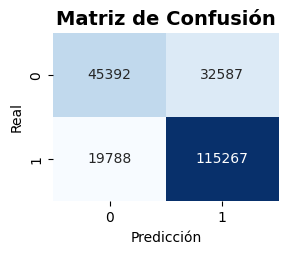

In [36]:
# 1. Confusion Matrix
print('\n1️⃣ Matriz de Confusión...')
ax1 = plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
ax1.set_title('Matriz de Confusión', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicción')
ax1.set_ylabel('Real')

2️⃣ Curva ROC...


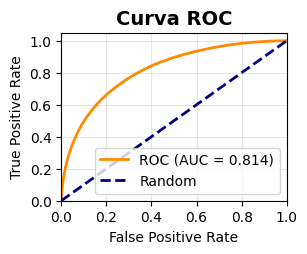

In [37]:
# 2. ROC Curve
print('2️⃣ Curva ROC...')
ax2 = plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Curva ROC', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

3️⃣ Feature Importance...


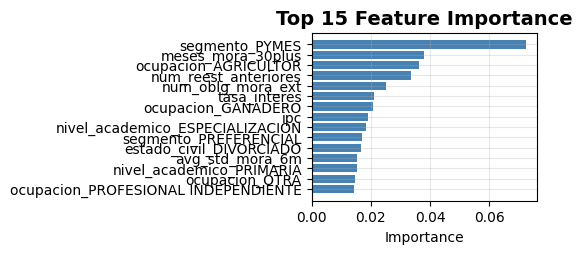

In [40]:

print('3️⃣ Feature Importance...')
ax3 = plt.subplot(2, 2, 3)
if hasattr(best_estimator, 'feature_importances_'):
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_estimator.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(15)
    
    ax3.barh(importances['Feature'], importances['Importance'], color='steelblue')
    ax3.set_xlabel('Importance')
    ax3.set_title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'Feature Importance no disponible\npara este modelo', 
             ha='center', va='center', fontsize=12)
    ax3.set_title('Feature Importance', fontsize=14, fontweight='bold')

In [52]:
import pickle
import joblib
import json
from datetime import datetime

print('='*70)
print('GUARDANDO MODELO Y ARTEFACTOS')
print('='*70)


# 1. Guardar modelo
print('\nGuardando modelo...')
with open('modelo.pkl', 'wb') as f:
    pickle.dump(best_estimator, f)


# 2. Guardar feature names
print('\nGuardando feature names...')
feature_info = {
    'features': X_train.columns.tolist(),
    'n_features': len(X_train.columns),
    'target_name': 'cumple_6m'  # Ajusta si es diferente
}

# Cambiar /tmp/ por una ruta de Windows o ruta relativa
with open('feature_names.json', 'w') as f:  # Se guardará en el directorio actual
    json.dump(feature_info, f, indent=2)
print('Features guardados: feature_names.json')

# 3. Guardar métricas completas
print('\nGuardando métricas...')

# Obtener tipo de modelo
model_type = type(best_estimator).__name__

# Obtener parámetros del modelo
model_params = best_estimator.get_params()

metrics = {
    'model_info': {
        'model_type': model_type,
        'training_date': datetime.now().isoformat(),
        'train_size': X_train.shape[0],
        'test_size': X_test.shape[0],
        'n_features': X_train.shape[1],
        'balance_method': 'SMOTE + ENN',
        'optimization': 'Optuna (TPE)',
        'cv_folds': 5
    },
    'hyperparameters': {k: str(v) for k, v in model_params.items()},
    'performance': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc)
    },
    'confusion_matrix': {
        'true_negatives': int(cm[0, 0]),
        'false_positives': int(cm[0, 1]),
        'false_negatives': int(cm[1, 0]),
        'true_positives': int(cm[1, 1])
    }
}

with open('model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print('Métricas guardadas: model_metrics.json')

# 4. Guardar classification report
print('\nGuardando classification report...')
report = classification_report(y_test, y_pred, output_dict=True)

with open('classification_report.json', 'w') as f:
    json.dump(report, f, indent=2)
print('Report guardado: classification_report.json')

# 5. Guardar feature importance (si disponible)
if hasattr(best_estimator, 'feature_importances_'):
    print('\nGuardando feature importance...')
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_estimator.feature_importances_
    }).sort_values('importance', ascending=False)
    
    importance_df.to_csv('feature_importance.csv', index=False)
    print('Feature importance guardado: feature_importance.csv')

GUARDANDO MODELO Y ARTEFACTOS

Guardando modelo...

Guardando feature names...
Features guardados: feature_names.json

Guardando métricas...
Métricas guardadas: model_metrics.json

Guardando classification report...
Report guardado: classification_report.json

Guardando feature importance...
Feature importance guardado: feature_importance.csv
